# MultiTask

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
img_zip_path = "/content/gdrive/MyDrive/CelebA_Dataset.zip"

In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
     

In [ ]:

zip_ref = zipfile.ZipFile(img_zip_path, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
labels_path = '/content/list_attr_celeba.txt'

In [ ]:

labels_df = pd.read_csv(labels_path)

In [ ]:

labels_df.head()

,202599
0,5_o_Clock_Shadow Arched_Eyebrows Attractive Ba...
1,000001.jpg -1 1 1 -1 -1 -1 -1 -1 -1 -1 -1 1...
2,000002.jpg -1 -1 -1 1 -1 -1 -1 1 -1 -1 -1 1...
3,000003.jpg -1 -1 -1 -1 -1 -1 1 -1 -1 -1 1 -1...
4,000004.jpg -1 -1 1 -1 -1 -1 -1 -1 -1 -1 -1 -1...


In [ ]:

label_dict = {}
for i in range(1, len(labels_df)):
    label_dict[labels_df['202599'][i].split()[0]] = [x for x in labels_df['202599'][i].split()[1:]]

In [ ]:
label_df = pd.DataFrame(label_dict).T

In [ ]:
label_df.head()

In [ ]:
label_df.columns = (labels_df['202599'][0]).split()

In [ ]:
label_df.replace(['-1'], ['0'], inplace = True)

In [ ]:

from PIL import Image

In [ ]:
Image.open('img_align_celeba/000001.jpg')

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif


In [ ]:
label_df

In [ ]:
# Split the data into features and target variable
X = label_df.iloc[:, :-1] # Extract all columns except the last one as features
y = label_df.iloc[:, -1] # Extract the last column as the target variable

# Use mutual information to select the top 8 features
k = 8 # Number of top features to select
selector = SelectKBest(mutual_info_classif, k=k)
selector.fit(X, y)
selected_features = X.columns[selector.get_support()]

# Print the names of the selected features
print(selected_features)

In [ ]:
label_df = label_df[selected_features]

# Print the first few rows of the subset
label_df.head()

In [ ]:
label_df.index

In [ ]:
from glob import glob
files = glob('img_align_celeba/*.jpg')     

In [ ]:
shuffle = np.random.permutation(len(files))

In [ ]:
for i in ['train', 'valid']:
    os.mkdir(os.path.join('/tmp/', i))

In [ ]:
!ls /tmp/

In [ ]:
files[10].split('/')[-1]

In [ ]:
((np.array(label_df[label_df.index==files[10].split('/')[-1]]))).shape

In [ ]:
from tqdm import tqdm
valid_dict = {}
valid_file_names = []
for i in tqdm(shuffle[:6000]):
    file_name = files[i].split('/')[-1]
    labels = np.array(label_df[label_df.index==file_name])
    valid_dict[file_name] = labels
    valid_file_names.append(file_name)
    os.rename(files[i], os.path.join('/tmp/', '/tmp/valid', file_name))
len(glob('/tmp/valid/*.jpg'))

100%|██████████| 6000/6000 [02:28<00:00, 40.46it/s]


6000

In [ ]:
len(valid_dict)

6000

In [ ]:
valid_dict

In [ ]:
len(glob('/tmp/valid/*.jpg'))

6000

In [ ]:
valid_df = pd.DataFrame([np.ravel(v) for v in valid_dict.values()], index=valid_dict.keys())


In [ ]:
valid_df

In [ ]:
valid_df.index = valid_file_names

In [ ]:
valid_df.head()

In [ ]:
valid_df['labels'] = valid_df.apply(lambda x: ''.join(x.astype(str)), axis=1)

# Remove original columns
valid_df = valid_df[['labels']]

In [ ]:
valid_df['labels'] = valid_df['labels'].apply(lambda x: [[int(c) for c in x]])

print(valid_df)

In [ ]:
valid_df

In [ ]:

train_dict = {}
train_file_names = []
for i in tqdm(shuffle[6000:18000 ]):
    file_name = files[i].split('/')[-1]
    labels = np.array(label_df[label_df.index==file_name])
    train_dict[file_name] = labels
    train_file_names.append(file_name)
    os.rename(files[i], os.path.join('/tmp/', '/tmp/train', file_name))

100%|██████████| 12000/12000 [04:52<00:00, 40.97it/s]


In [ ]:
train_df = pd.DataFrame([np.ravel(v) for v in train_dict.values()], index=train_dict.keys())
df_save=train_df
train_df.index = train_file_names
train_df['labels'] = train_df.apply(lambda x: ''.join(x.astype(str)), axis=1)
train_df = train_df[['labels']]
train_df['labels'] = train_df['labels'].apply(lambda x: [[int(c) for c in x]])

In [ ]:
train_df


In [ ]:
import torchvision

In [ ]:
from glob import glob
import os
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import models
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch.optim import lr_scheduler
from torch import optim
from torchvision.utils import make_grid
import time
%matplotlib inline

In [ ]:
from torch.utils.data import Dataset

class MultiClassCelebA(Dataset):
    
    def __init__(self, dataframe, folder_dir, transform = None):
        
        self.dataframe = dataframe
        self.folder_dir = folder_dir
        self.transform = transform
        self.file_names = dataframe.index
        self.labels = dataframe.labels.values.tolist()
        
        
    def __len__(self):
        return len(self.dataframe)
    
    
    def __getitem__(self, index):
        
        image = Image.open(os.path.join(self.folder_dir, self.file_names[index]))
        label = self.labels[index][0]
        label = [float(i) for i in label]
        label = np.array(label, dtype=float)
        

        sample = {'image': image, 'label': label}
        if self.transform:
            image = self.transform(sample['image'])
            sample = {'image': image, 'label': label}
        
        return sample

In [ ]:

tfms = transforms.Compose([transforms.Resize((128, 128)),
                           transforms.ToTensor()])

In [ ]:
train_dl = MultiClassCelebA(train_df, '/tmp/train/', transform = tfms)

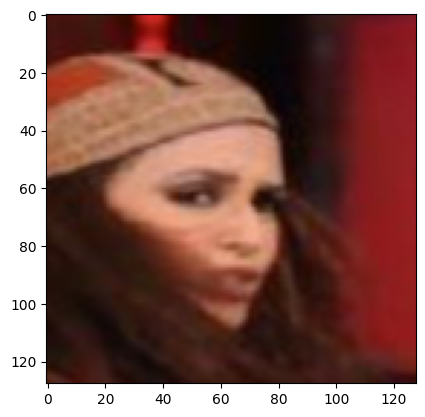

In [ ]:
plt.imshow(torchvision.utils.make_grid(train_dl[1]['image']).permute(1, 2, 0))

In [ ]:
type(train_dl[1]['label'][0])

numpy.float64

In [ ]:
valid_dl = MultiClassCelebA(valid_df, '/tmp/valid/', transform = tfms)

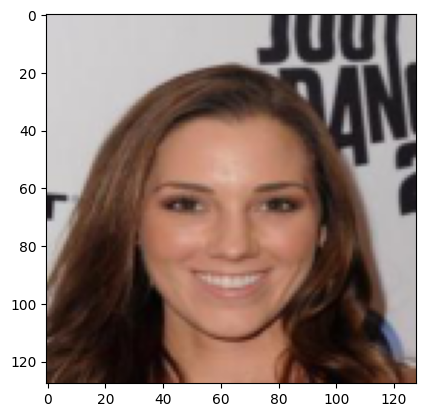

In [ ]:

plt.imshow(torchvision.utils.make_grid(valid_dl[1]['image']).permute(1,2,0))

In [ ]:
valid_dl[1]['label']

array([1., 0., 0., 0., 0., 1., 0., 1.])

In [ ]:
import torch.nn.functional as F

In [ ]:
train_dataloader = torch.utils.data.DataLoader(train_dl, shuffle = True, batch_size = 64, num_workers = 3)
valid_dataloader = torch.utils.data.DataLoader(valid_dl, shuffle = True, batch_size = 64, num_workers = 3)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

In [ ]:

# define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.backbone = resnet50(pretrained=False)
        self.backbone.fc = nn.Sequential()  
        self.fc1 = nn.Linear(2048, 1024)
        self.classifier1 = nn.Linear(1024, 1)
        self.classifier2 = nn.Linear(1024, 1)
        self.classifier3 = nn.Linear(1024, 1)
        self.classifier4 = nn.Linear(1024, 1)
        self.classifier5 = nn.Linear(1024, 1)
        self.classifier6 = nn.Linear(1024, 1)
        self.classifier7 = nn.Linear(1024, 1)
        self.classifier8 = nn.Linear(1024, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.fc1(x)
        #x = torch.flatten(x, 1)
        x1 = self.sigmoid(self.classifier1(x))
        x2 = self.sigmoid(self.classifier2(x))
        x3 = self.sigmoid(self.classifier3(x))
        x4 = self.sigmoid(self.classifier4(x))
        x5 = self.sigmoid(self.classifier5(x))
        x6 = self.sigmoid(self.classifier6(x))
        x7 = self.sigmoid(self.classifier7(x))
        x8 = self.sigmoid(self.classifier8(x))
        return x1, x2, x3, x4, x5, x6, x7, x8


In [ ]:
learning_rate = 0.001
batch_size = 64
num_epochs = 10

In [ ]:
criterion = nn.BCELoss()

In [ ]:
model=MyModel()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
model=model.to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_df

In [ ]:
hard_labels1=df_save[0].tolist()
hard_labels2=df_save[1].tolist()
hard_labels3=df_save[2].tolist()
hard_labels4=df_save[3].tolist()
hard_labels5=df_save[4].tolist()
hard_labels6=df_save[5].tolist()
hard_labels7=df_save[6].tolist()
hard_labels8=df_save[7].tolist()


In [ ]:
def return_bool(binary_list):
  bool_list = [bool(x) for x in binary_list]
  return bool_list

In [ ]:
hard_labels1= return_bool(hard_labels1)
hard_labels2= return_bool(hard_labels2)
hard_labels3= return_bool(hard_labels3)
hard_labels4= return_bool(hard_labels4)
hard_labels5= return_bool(hard_labels5)
hard_labels6= return_bool(hard_labels6)
hard_labels7= return_bool(hard_labels7)
hard_labels8= return_bool(hard_labels8)


In [ ]:
len(hard_labels1)

In [ ]:
import random

In [ ]:
def convert_bool_to_float(lst):
    result = []
    for value in lst:
        if value == False:
            result.append(round(random.uniform(0, 0.5), 2))
        else:
            result.append(round(random.uniform(0.5, 0.99), 2))
    return result

In [ ]:
soft_labels1=convert_bool_to_float(hard_labels1)

In [ ]:
soft_labels1

In [ ]:
type(soft_labels1)

In [ ]:
soft_np=np.array(soft_labels1)

In [ ]:
import numpy as np
import torchvision
import scipy
from scipy import stats

In [ ]:

min_soft = np.min(np.stack((soft_np, 1-soft_np)), axis=0)
hatBER = np.mean(min_soft)

conf_level = 0.95
df = len(soft_np) - 1
hatBERse = stats.sem(min_soft)
conf_interval = scipy.stats.t.interval(conf_level, df, hatBER, hatBERse)
print(f'Bayes error : {hatBER*10:.3f}% ({conf_interval[0]*100:.3f}%, {conf_interval[1]*100:.3f}%)')

lambda1=hatBER

Bayes error : 2.562% (25.368%, 25.873%)


# DST

In [ ]:
def return_bayes(soft_labels1):
  soft_labels1=soft_labels1.cpu().detach().numpy()
  min_soft = np.min(np.stack((soft_np, 1-soft_np)), axis=0)
  hatBER = np.mean(min_soft)

  conf_level = 0.95
  df = len(soft_np) - 1
  hatBERse = stats.sem(min_soft)
  conf_interval = scipy.stats.t.interval(conf_level, df, hatBER, hatBERse)
  return hatBERse


In [ ]:
def returnG(p):
  dist = torch.distributions.Bernoulli(probs=p)

# sample from the distribution
  sample = dist.sample()

  return sample

In [ ]:
def Bgate(error,bayes):
  if(error<=bayes):
    return 0

  else:
     return 1   

In [ ]:
bayes=[]

In [ ]:
import numpy as np

for i in range(1, 9):
    # Read soft labels from file
    filename = "/content/softlabel_" + str(i) + ".txt"
    soft_labels = np.loadtxt(filename)
    bayes_error= return_bayes(soft_labels)
    bayes.append(bayes_error)

   



In [ ]:
import numpy as np

# Read soft labels from file
soft_labels = np.loadtxt("softlabels.txt")

# Calculate Bayes error rate
num_classes = soft_labels.shape[1]
bayes_error = 1 - np.max(soft_labels, axis=1).mean()

print("Bayes error rate:", bayes_error)

In [ ]:
cutoff=[]

In [ ]:
criterion = nn.BCELoss()

# Initialize the model
model = MyModel().to(device)

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
v1=0
v2=0
v3=0
v4=0
v5=0
v6=0
v7=0
v8=0

overallaccuracy=[]
overallloss=[]

taskloss=[[],[],[],[],[],[],[],[]]
error_rate=[[],[],[],[],[],[],[],[]]
taskaccuracy=[[],[],[],[],[],[],[],[]]

droprates=[[],[],[],[],[],[],[],[]]
lambdap=0.5
pbt=1
for epoch in range(num_epochs):
    train_loss=0
    task_losses = [0]*8
    task_dropouts = [0]*8
    task_correct = [0]*8
    total_samples = 0
    overall_acc =0
    if(epoch==0):

        for i, data in enumerate(train_dataloader):
            inputs, target = data['image'], data['label'].float()
            
            inputs, target = Variable(inputs).to(device), Variable(target).to(device)
            optimizer.zero_grad()
            o1, o2, o3, o4, o5, o6, o7, o8 = model(inputs)
            
            total_samples += target.size(0)

            loss1 = criterion(torch.flatten(o1),  target[:,0])
            loss2 = criterion(torch.flatten(o2), target[:,1])
            loss3 = criterion(torch.flatten(o3), target[:,2])
            loss4 = criterion(torch.flatten(o4), target[:,3])
            loss5 = criterion(torch.flatten(o5), target[:,4])
            loss6 = criterion(torch.flatten(o6), target[:,5])
            loss7 = criterion(torch.flatten(o7), target[:,6])
            loss8 = criterion(torch.flatten(o8), target[:,7])



            task_losses[0] += loss1.item()
            task_losses[1] += loss2.item()
            task_losses[2] += loss3.item()
            task_losses[3] += loss4.item()
            task_losses[4] += loss5.item()
            task_losses[5] += loss6.item()
            task_losses[6] += loss7.item()
            task_losses[7] += loss8.item()


            task_correct[0] += ((o1 > 0.5) == target[:, 0].unsqueeze(1)).sum().item()
            task_correct[1] += ((o2 > 0.5) == target[:, 1].unsqueeze(1)).sum().item()
            task_correct[2] += ((o3 > 0.5) == target[:, 2].unsqueeze(1)).sum().item()
            task_correct[3] += ((o4 > 0.5) == target[:, 3].unsqueeze(1)).sum().item()
            task_correct[4] += ((o5 > 0.5) == target[:, 4].unsqueeze(1)).sum().item()
            task_correct[5] += ((o6 > 0.5) == target[:, 5].unsqueeze(1)).sum().item()
            task_correct[6] += ((o7 > 0.5) == target[:, 6].unsqueeze(1)).sum().item()
            task_correct[7] += ((o8 > 0.5) == target[:, 7].unsqueeze(1)).sum().item()
            
            
            loss = criterion(torch.cat([o1, o2, o3, o4, o5, o6, o7, o8], dim=1), target)
            train_loss=train_loss+loss.item()
            overall_acc = sum(task_correct)/total_samples
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch},  Overall Accuracy = {overall_acc/8*100}")
        overallaccuracy.append(overall_acc/8*100)
        print(f"Epoch {epoch}, Loss = {train_loss/len(train_dataloader)}")
        overallloss.append(train_loss/len(train_dataloader))
        v1=task_losses[0]/len(train_dataloader)
        v2=task_losses[1]/len(train_dataloader)
        v3=task_losses[2]/len(train_dataloader)
        v4=task_losses[3]/len(train_dataloader)
        v5=task_losses[4]/len(train_dataloader)
        v6=task_losses[5]/len(train_dataloader)
        v7=task_losses[6]/len(train_dataloader)
        v8=task_losses[7]/len(train_dataloader)
        for i in range(8):
          error_rate[i].append(1-(task_correct[i]/total_samples))
          taskloss[i].append(task_losses[i]/len(train_dataloader)) 
          taskaccuracy[i].append(task_correct[i]/total_samples*100)
          print(f"Task {i+1}, Loss = {task_losses[i]/len(train_dataloader)}, Accuracy = {task_correct[i]/total_samples*100},error_rate={1-(task_correct[i]/total_samples)}") 

    else:

      for i, data in enumerate(train_dataloader):
            inputs, target = data['image'], data['label'].float()
            
            inputs, target = Variable(inputs).to(device), Variable(target).to(device)
            optimizer.zero_grad()
            o1, o2, o3, o4, o5, o6, o7, o8 = model(inputs)
            
            total_samples += target.size(0)
            loss1 = criterion(torch.flatten(o1),  target[:,0])
            loss2 = criterion(torch.flatten(o2), target[:,1])
            loss3 = criterion(torch.flatten(o3), target[:,2])
            loss4 = criterion(torch.flatten(o4), target[:,3])
            loss5 = criterion(torch.flatten(o5), target[:,4])
            loss6 = criterion(torch.flatten(o6), target[:,5])
            loss7 = criterion(torch.flatten(o7), target[:,6])
            loss8 = criterion(torch.flatten(o8), target[:,7])

           

            i1=loss1/v1
            i2=loss2/v2
            i3=loss3/v3
            i4=loss4/v4
            i5=loss5/v1
            i6=loss6/v6
            i7=loss7/v7
            i8=loss8/v8

            e=(i1+i2+i3+i4+i5+i6+i7+i8)/8

            p1=lambdap*(torch.min(torch.tensor(1),i1/e)) +(1-lambdap)*pbt
            p2=lambdap*(torch.min(torch.tensor(1),i2/e)) +(1-lambdap)*pbt
            p3=lambdap*(torch.min(torch.tensor(1),i3/e)) +(1-lambdap)*pbt
            p4=lambdap*(torch.min(torch.tensor(1),i4/e)) +(1-lambdap)*pbt
            p5=lambdap*(torch.min(torch.tensor(1),i5/e)) +(1-lambdap)*pbt
            p6=lambdap*(torch.min(torch.tensor(1),i6/e)) +(1-lambdap)*pbt
            p7=lambdap*(torch.min(torch.tensor(1),i7/e)) +(1-lambdap)*pbt
            p8=lambdap*(torch.min(torch.tensor(1),i8/e)) +(1-lambdap)*pbt

            task_dropouts[0] += p1
            task_dropouts[1] += p2
            task_dropouts[2] += p3
            task_dropouts[3] += p4
            task_dropouts[4] += p5
            task_dropouts[5] += p6
            task_dropouts[6] += p7
            task_dropouts[7] += p8  


            b1=Bgate(error_rate[0][-1],bayes[0])
            b2=Bgate(error_rate[1][-1],bayes[1])
            b3=Bgate(error_rate[2][-1],bayes[2])
            b4=Bgate(error_rate[3][-1],bayes[3])
            b5=Bgate(error_rate[4][-1],bayes[4])
            b6=Bgate(error_rate[5][-1],bayes[5])
            b7=Bgate(error_rate[6][-1],bayes[6])
            b8=Bgate(error_rate[7][-1],bayes[7])

            if any(b == 0 for b in [b1, b2, b3, b4, b5, b6, b7, b8]):
                  print("cutoff reached")
                  print(b1, b2, b3, b4, b5, b6, b7, b8)


            g1=returnG(p1)
            g2=returnG(p2)
            g3=returnG(p3)
            g4=returnG(p4)
            g5=returnG(p5)
            g6=returnG(p6)
            g7=returnG(p7)
            g8=returnG(p8)

            task_losses[0] += loss1.item()
            task_losses[1] += loss2.item()
            task_losses[2] += loss3.item()
            task_losses[3] += loss4.item()
            task_losses[4] += loss5.item()
            task_losses[5] += loss6.item()
            task_losses[6] += loss7.item()
            task_losses[7] += loss8.item()


          
            task_correct[0] += ((o1 > 0.5) == target[:, 0].unsqueeze(1)).sum().item()
            task_correct[1] += ((o2 > 0.5) == target[:, 1].unsqueeze(1)).sum().item()
            task_correct[2] += ((o3 > 0.5) == target[:, 2].unsqueeze(1)).sum().item()
            task_correct[3] += ((o4 > 0.5) == target[:, 3].unsqueeze(1)).sum().item()
            task_correct[4] += ((o5 > 0.5) == target[:, 4].unsqueeze(1)).sum().item()
            task_correct[5] += ((o6 > 0.5) == target[:, 5].unsqueeze(1)).sum().item()
            task_correct[6] += ((o7 > 0.5) == target[:, 6].unsqueeze(1)).sum().item()
            task_correct[7] += ((o8 > 0.5) == target[:, 7].unsqueeze(1)).sum().item()
            
            
            loss = (loss1*g1*b1 + loss2*g2*b2 + loss3*g3*b3 + loss4*g4*b4+ loss5*g5*b5 + loss6*g6*b6 + loss7*g7*b7 + loss8*g8*b8)/(g1+g2+g3+g4+g5+g6+g7)
            train_loss=train_loss+loss.item()
            overall_acc = sum(task_correct)/total_samples
            loss.backward()
            optimizer.step()
            
      
      print(f"Epoch {epoch},  Overall Accuracy = {overall_acc/8*100}")
      overallaccuracy.append(overall_acc/8*100)
      print(f"Epoch {epoch}, Loss = {train_loss/len(train_dataloader)}")
      overallloss.append(train_loss/len(train_dataloader))
      for i in range(8):
         error_rate[i].append(1-(task_correct[i]/total_samples))
         taskloss[i].append(task_losses[i]/len(train_dataloader)) 
         taskaccuracy[i].append(task_correct[i]/total_samples*100)
         droprates[i].append(task_dropouts[i]/len(train_dataloader))
         print(f"Task {i+1}, Loss = {task_losses[i]/len(train_dataloader)}, Accuracy = {task_correct[i]/total_samples*100},error_rate={1-(task_correct[i]/total_samples)}")     

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Epoch 0,  Overall Accuracy = 73.11041666666667
Epoch 0, Loss = 1.0591303398634524
Task 1, Loss = 1.554280088937029, Accuracy = 55.43333333333334,error_rate=0.44566666666666666
Task 2, Loss = 1.2494918429788122, Accuracy = 75.125,error_rate=0.24875000000000003
Task 3, Loss = 0.3632861401732242, Accuracy = 94.46666666666667,error_rate=0.055333333333333345
Task 4, Loss = 0.34285454690317685, Accuracy = 94.84166666666667,error_rate=0.051583333333333314
Task 5, Loss = 0.2989799503554055, Accuracy = 95.35,error_rate=0.046499999999999986
Task 6, Loss = 1.406816025680684, Accuracy = 59.88333333333333,error_rate=0.40116666666666667
Task 7, Loss = 1.5641779557187507, Accuracy = 55.95833333333333,error_rate=0.4404166666666667
Task 8, Loss = 1.6931561295022355, Accuracy = 53.825,error_rate=0.46175
Epoch 1,  Overall Accuracy = 77.51041666666667
Epoch 1, Loss = 0.7643438194026339
Task 1, Loss = 0.84205842842447, Accuracy = 61.05833333333334,error_rate=0.38941666666666663
Task 2, Loss = 0.66827132029

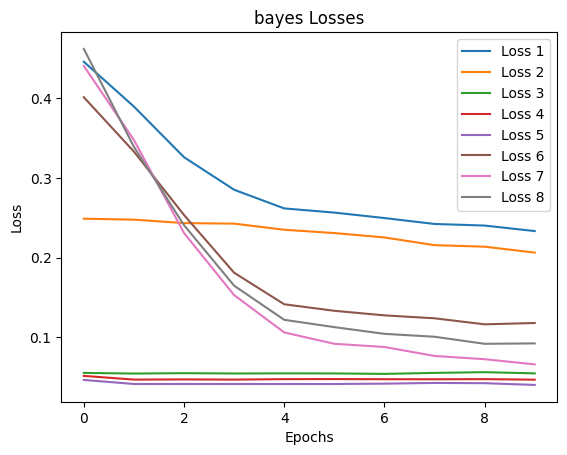

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot all 8 lists on the same plot
ax.plot(error_rate[0],label='Loss 1')
ax.plot(error_rate[1],label='Loss 2')
ax.plot(error_rate[2],label='Loss 3')
ax.plot(error_rate[3],label='Loss 4')
ax.plot(error_rate[4],label='Loss 5')
ax.plot(error_rate[5],label='Loss 6')
ax.plot(error_rate[6],label='Loss 7')
ax.plot(error_rate[7],label='Loss 8')




# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('bayes Losses')
ax.legend()
# Show the plot
plt.show()

In [ ]:
task_correct = [0]*8
total_samples = 0
overall_acc =0
for i, data in enumerate(valid_dataloader):
        model.eval()
        inputs, target = data['image'], data['label'].float()
        
        inputs, target = Variable(inputs).to(device), Variable(target).to(device)
        optimizer.zero_grad()
        o1, o2, o3, o4, o5, o6, o7, o8 = model(inputs)
        
        total_samples += target.size(0)
        
      
        task_correct[0] += ((o1 > 0.5) == target[:, 0].unsqueeze(1)).sum().item()
        task_correct[1] += ((o2 > 0.5) == target[:, 1].unsqueeze(1)).sum().item()
        task_correct[2] += ((o3 > 0.5) == target[:, 2].unsqueeze(1)).sum().item()
        task_correct[3] += ((o4 > 0.5) == target[:, 3].unsqueeze(1)).sum().item()
        task_correct[4] += ((o5 > 0.5) == target[:, 4].unsqueeze(1)).sum().item()
        task_correct[5] += ((o6 > 0.5) == target[:, 5].unsqueeze(1)).sum().item()
        task_correct[6] += ((o7 > 0.5) == target[:, 6].unsqueeze(1)).sum().item()
        task_correct[7] += ((o8 > 0.5) == target[:, 7].unsqueeze(1)).sum().item()
        
 
        overall_acc = sum(task_correct)/total_samples
    
print(overall_acc/8*100)

for i in range(8):

        
         print(f"Task {i+1}, Loss = {task_correct[i]/total_samples*100}")

88.33958333333334
Task 1, Loss = 75.58333333333334
Task 2, Loss = 79.06666666666666
Task 3, Loss = 93.98333333333333
Task 4, Loss = 95.06666666666666
Task 5, Loss = 94.86666666666666
Task 6, Loss = 87.25
Task 7, Loss = 90.88333333333334
Task 8, Loss = 90.01666666666667


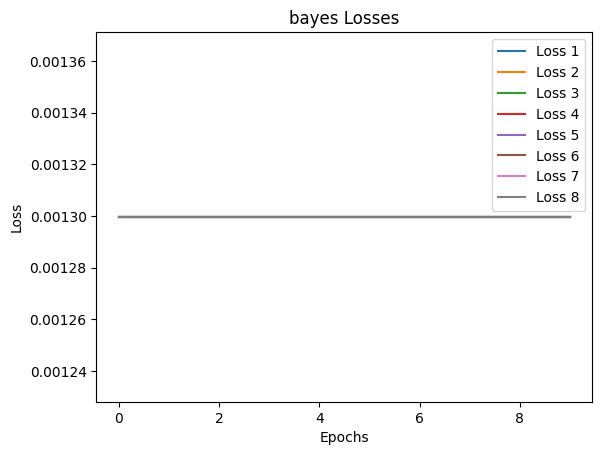

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot all 8 lists on the same plot
ax.plot(bayesloss[0],label='Loss 1')
ax.plot(bayesloss[1],label='Loss 2')
ax.plot(bayesloss[2],label='Loss 3')
ax.plot(bayesloss[3],label='Loss 4')
ax.plot(bayesloss[4],label='Loss 5')
ax.plot(bayesloss[5],label='Loss 6')
ax.plot(bayesloss[6],label='Loss 7')
ax.plot(bayesloss[7],label='Loss 8')




# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('bayes Losses')
ax.legend()
# Show the plot
plt.show()

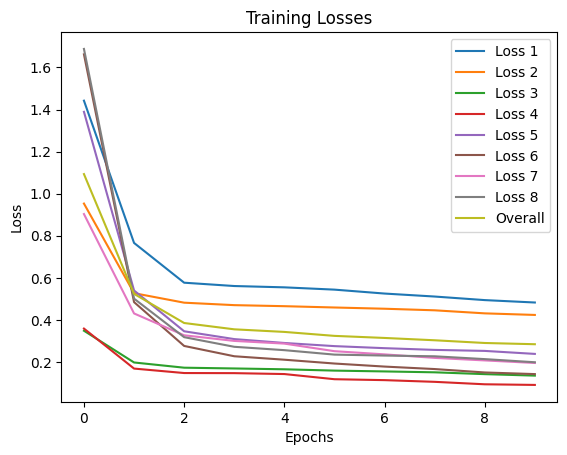

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot all 8 lists on the same plot
ax.plot(taskloss[0],label='Loss 1')
ax.plot(taskloss[1],label='Loss 2')
ax.plot(taskloss[2],label='Loss 3')
ax.plot(taskloss[3],label='Loss 4')
ax.plot(taskloss[4],label='Loss 5')
ax.plot(taskloss[5],label='Loss 6')
ax.plot(taskloss[6],label='Loss 7')
ax.plot(taskloss[7],label='Loss 8')
ax.plot(overallloss,label='Overall')



# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Loss')

# Set the title of the plot
ax.set_title('Training Losses')
ax.legend()
# Show the plot
plt.show()

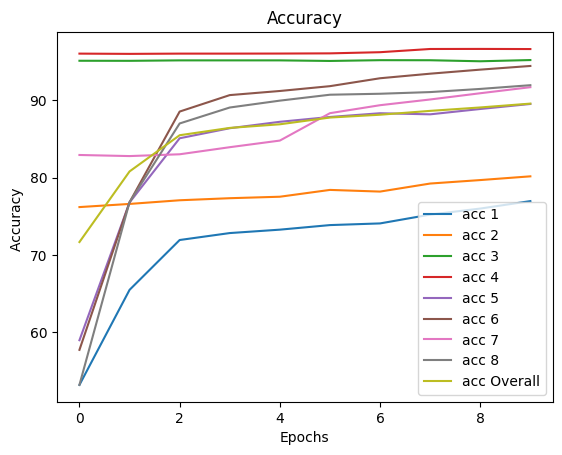

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot all 8 lists on the same plot
ax.plot(taskaccuracy[0],label='acc 1')
ax.plot(taskaccuracy[1],label='acc 2')
ax.plot(taskaccuracy[2],label='acc 3')
ax.plot(taskaccuracy[3],label='acc 4')
ax.plot(taskaccuracy[4],label='acc 5')
ax.plot(taskaccuracy[5],label='acc 6')
ax.plot(taskaccuracy[6],label='acc 7')
ax.plot(taskaccuracy[7],label='acc 8')
ax.plot(overallaccuracy,label='acc Overall')



# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Accuracy ')

# Set the title of the plot
ax.set_title('Accuracy')
ax.legend()
# Show the plot
plt.show()

In [ ]:
droprates[0]

[tensor(0.9826, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9923, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9948, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9973, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9972, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9962, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9978, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9966, device='cuda:0', grad_fn=<DivBackward0>),
 tensor(0.9973, device='cuda:0', grad_fn=<DivBackward0>)]

In [ ]:
def taskwise_activation_numpy(tensor_list):
  numpy_list = [tensor.cpu().detach().numpy() for tensor in tensor_list]

  return numpy_list


In [ ]:
def Gactivation(tensor_list):
  numpy_list = [returnG(tensor).cpu().detach().numpy() for tensor in tensor_list]

  return numpy_list


In [ ]:
def droprate_from_taskwise(tensor_list):
  numpy_list = [ 2*tensor.cpu().detach().numpy()-1 for tensor in tensor_list]

  return numpy_list

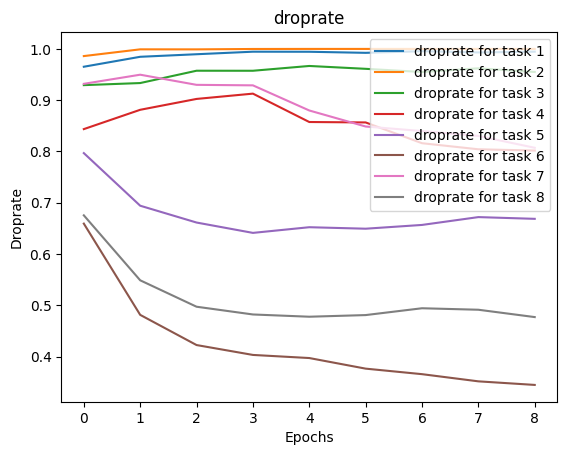

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()


# Plot all 8 lists on the same plot
ax.plot(droprate_from_taskwise(droprates[0]),label='droprate for task 1')
ax.plot(droprate_from_taskwise(droprates[1]),label='droprate for task 2')
ax.plot(droprate_from_taskwise(droprates[2]),label='droprate for task 3')
ax.plot(droprate_from_taskwise(droprates[3]),label='droprate for task 4')
ax.plot(droprate_from_taskwise(droprates[4]),label='droprate for task 5')
ax.plot(droprate_from_taskwise(droprates[5]),label='droprate for task 6')
ax.plot(droprate_from_taskwise(droprates[6]),label='droprate for task 7')
ax.plot(droprate_from_taskwise(droprates[7]),label='droprate for task 8')




# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Droprate')

# Set the title of the plot
ax.set_title('droprate')
ax.legend(loc='upper right')
# Show the plot
plt.show()

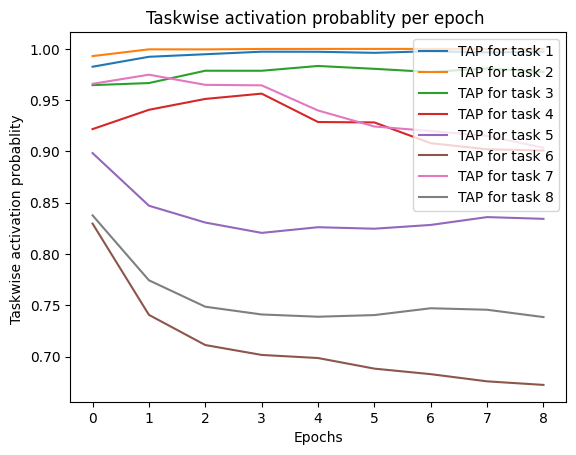

In [ ]:
import matplotlib.pyplot as plt
# Create a figure and axis object
fig, ax = plt.subplots()

# Plot all 8 lists on the same plot
ax.plot(taskwise_activation_numpy(droprates[0]),label='TAP for task 1')
ax.plot(taskwise_activation_numpy(droprates[1]),label='TAP for task 2')
ax.plot(taskwise_activation_numpy(droprates[2]),label='TAP for task 3')
ax.plot(taskwise_activation_numpy(droprates[3]),label='TAP for task 4')
ax.plot(taskwise_activation_numpy(droprates[4]),label='TAP for task 5')
ax.plot(taskwise_activation_numpy(droprates[5]),label='TAP for task 6')
ax.plot(taskwise_activation_numpy(droprates[6]),label='TAP for task 7')
ax.plot(taskwise_activation_numpy(droprates[7]),label='TAP for task 8')




# Set the x-axis label
ax.set_xlabel('Epochs')

# Set the y-axis label
ax.set_ylabel('Taskwise activation probablity ')

# Set the title of the plot
ax.set_title('Taskwise activation probablity per epoch ')
ax.legend(loc='upper right')
# Show the plot
plt.show()

In [ ]:
Activayionfortasks=[[],[],[],[],[],[],[],[]]

In [ ]:
for i in range(8):
  Activayionfortasks[i]=Gactivation(droprates[i])

In [ ]:
Activayionfortasks

In [ ]:
len(Activayionfortasks[1])

9

In [ ]:
signal=Activayionfortasks[7]

In [ ]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black']

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]


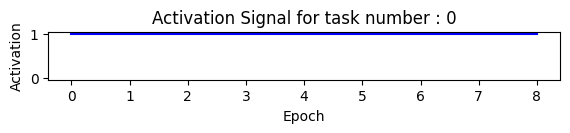

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]


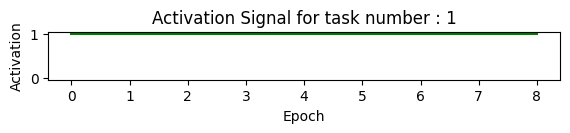

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]


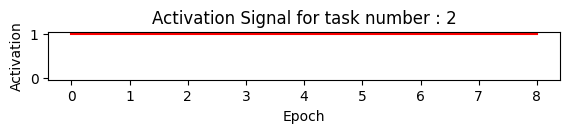

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32)]


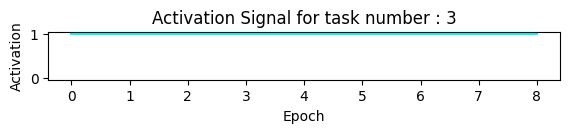

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0., dtype=float32)]


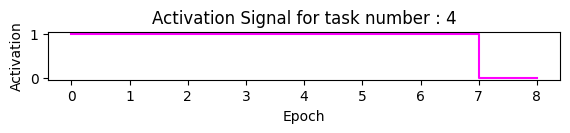

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0., dtype=float32), array(1., dtype=float32)]


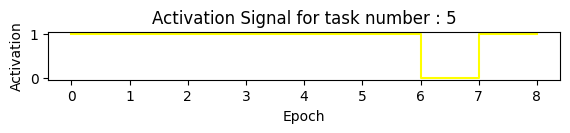

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0., dtype=float32), array(0., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0., dtype=float32)]


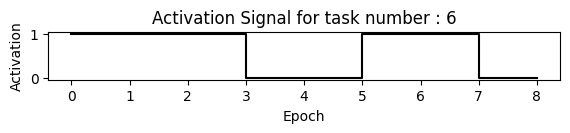

[array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(1., dtype=float32), array(0., dtype=float32)]


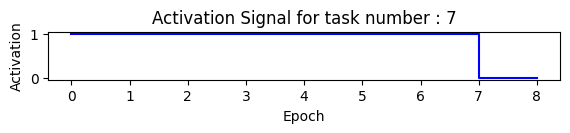

In [ ]:
for i in range(8):
  signal=Activayionfortasks[i]
  x = list(range(len(signal)))
  print(signal)
  # plot the signal
  plt.step(x, signal,color=colors[i % len(colors)])
  
  task=i
  # add labels and title
  plt.xlabel('Epoch')
  plt.ylabel('Activation')
  plt.title(f'Activation Signal for task number : {task}')
  plt.ylim(-0.05, 1.05)
  plt.subplots_adjust(left=0.1, bottom=0.2, right=0.9, top=0.3)
  # display the plot
  plt.show()
  plt.close()